
## Sesión 4.Introducción al Aprendizaje por Refuerzo en entornos discretos
#### Inteligencia Artificial 2024 / 25
##### Belén Díaz Agudo 

## Librería OpenAI Gym  y Gymnasium

[OpenAI Gym](https://www.gymlibrary.dev/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál podemos diseñar y probar agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos con el mismo entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. La librería ha evolucionado a una nueva versión, [gymnasium](https://gymnasium.farama.org/index.html) que es compatible con los entornos anteriores realizados en gym. 
Aunque la práctica también se puede hacer con la librería gym utilizaremos gymnasium que es una librería más moderna. Necesitaremos instalar las librerías numpy, gymnasium y pygame. 


La interfaz principal de los entornos (environments) de gym es la interfaz __env__ con 5 métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla el entorno.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.
To get reproducible sampling of actions, a seed can be set with env.action_space.seed(123).

Puedes consultar la documentación de los entornos en https://gymnasium.farama.org/api/env/#gymnasium.Env

Cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

## Ejemplo 1. Taxi

En este ejemplo hay 4 ubicaciones (etiquetadas con letras o colores diferentes) y nuestro trabajo es recoger al pasajero en una ubicación de origen y dejarlo en otra posición destino. El taxi solo puede coger y dejar pasajeros en las 4 posiciones marcadas.

Como recompensa recibimos +20 puntos por dejar al pasajero con éxito y perderemos 1 punto por cada paso de tiempo. También hay una penalización de 10 puntos por acciones ilegales de recoger y dejar en ubicaciones no válidas.

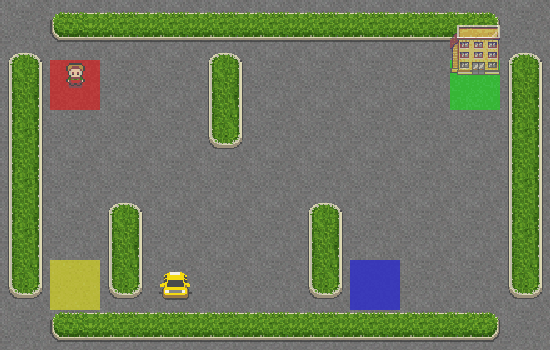

Revisa la documentación del entorno en Gymnasium [https://gymnasium.farama.org/environments/toy_text/taxi/](https://gymnasium.farama.org/environments/toy_text/taxi/)

In [9]:
import gymnasium as gym
#inicializamos en entorno gym con el problema del taxi y visualización gráfica.
env = gym.make("Taxi-v3", render_mode="human")

Vamos a observar algunos datos del entorno, en concreto cuantos estados y acciones tenemos.

In [ ]:
print("Tamaño de espacio de estados", env.observation_space)
print("Estado aleatorio", env.observation_space.sample())
size_estados = env.observation_space.n
print("Hay", size_estados, " estados posibles.")
print("Acciones posibles", env.action_space.n)
print("Acción aleatoria", env.action_space.sample())
size_acciones = env.action_space.n
print("Hay", size_acciones, " acciones posibles.")


Tamaño de espacio de estados Discrete(500)
Estado aleatorio 369
Hay 500  estados posibles.
Acciones posibles 6
Acción aleatoria 5
Hay 6  acciones posibles.


In [ ]:
# Podemos crear un estado aleatorio con reset y visualizarlo con render
env.reset()
env.render()
# En este ejemplo, la visualización "humana" suele dar problemas y para este ejemplo vamos a usar una visualizacion más sencilla (ansi). 
# Se puede configurar el tipo de visualización en el make. 

In [ ]:
# Cuando termines de trabajar es importante cerrar el entorno. Puedes volver a crearlo con make.
env.close()

In [ ]:
# la visualizacion humana está bien, pero si queremos hacer un experimento con muchos episodios, es mejor no visualizarlo. 
# En este ejemplo vamos a usar una visualización en modo texto para poder
# guardar los tableros en un diccionario para visualizarlo despues del entrenamiento. 
# Usaremos en el make una de las opciones adicioanles de visualización, en concreto "ansi" 
env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()
print(env.render())
# Recuerda que debers cerrar el entorno con problema.close() al finalizar. Ahora no vamos a cerrarlo de momento porque seguimos trabajando. 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




- El cuadrado representa el taxi. Es amarillo sin pasajero y verde cuando lleva pasajero.
- La marca ("|") representa una pared que el taxi no puede cruzar.
- R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra que esté coloreada en azul representa la ubicación actual de recogida de pasajeros y la letra rosa es el destino actual.

In [ ]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


Lo primero siempre es entender el entorno. 

El Action Space tiene tamaño 6 (hay 6 acciones) y el State Space tiene tamaño 500 (500 estados). El algoritmo RL no necesita más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de forma única asignando un número único a cada estado posible, y RL aprende a elegir un número de la acción más conveniente en ese estado. Las 6 acciones se numeran de 0 a 5 donde:
   - 0 = sur
   - 1 = norte
   - 2 = este
   - 3 = oeste
   - 4 = recoger
   - 5 = dejar

¿Entiendes por qué hay 500 estados diferentes?  
Los 500 estados corresponden a una codificación de la ubicación del taxi (fila 0..4, columna 0..4), la ubicación inicial, la ubicación actual del pasajero (5 valores posibles: 4 posiciones R(0), G(1), Y(2), B(3) o en el taxi (4)) y la ubicación de destino (4 valores posibles R(0), G(1), Y(2), B(3)): 5x5x5x4 = 500

La coordenadas (0,0) es la esquina superior izquierda del tablero.

El aprendizaje por refuerzo aprenderá un mapeo de los estados con las acciones óptimas. Este aprendizaje se guarda en la matriz Q. 
Durante el aprendizaje realizaremos un proceso de _exploración_, es decir, el agente explora el entorno y toma acciones basadas en las recompensas definidas en el entorno. 

La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulativa a largo plazo según la fórmula vista para el Q-learning.


In [ ]:
# Observa y ejecuta este fragmento de código en el que se intenta resolver el problema realizando 
# acciones aleatorias sobre el tablero del taxi. 
# Lo normal es que no resuelva el problema :) 
# Se guardan los estados en un diccionario. Puedes ver luego la animación en la siguiente celda.

epochs = 0
penalties, reward = 0, 0
frames = [] # for animation
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, info, _ = env.step(action)
    if reward == -10:
        penalties += 1
    # Guardamos cada frame en un diccionario y despues veremos la animación. 
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 2643
Penalties incurred: 833


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames,time=.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(time)

In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 12
State: 254
Action: 3
Reward: -1


KeyboardInterrupt: 

En esta versión el agente va totalmente a ciegas __sin aprender__. Utiliza miles de pasos de tiempo y realiza muchos drop-offs incorrectos para entregar un solo pasajero al destino correcto (cuando acierte de casualidad). ¿Ha tardado mucho en acertar de casualidad?  
Vamos a resolverlo con Aprendizaje por refuerzo que empieza haciendo ciclos a ciegas pero a la vez aprendiendo de la experiencia. Realizará pasos de forma aleatoria y, cuando "por casualidad" acertamos, el agente guarda en la memoria (en forma de recompensa) qué acción fue la mejor para cada estado. Así en el futuro elegirá esa acción. Los éxitos se propagan hacia atrás en la cadena de acciones usando la fórmula del Q-Learning.

In [ ]:
env.close()

### Aprendizaje por refuerzo

Vamos a utilizar el algoritmo de Q-learning que hemos visto en clase y que le dará a nuestro agente algo de memoria.
Básicamente, Q-learning permite al agente utilizar las recompensas del entorno para aprender, con el tiempo, la mejor acción a realizar en un estado determinado.
En nuestro entorno de Taxi, tenemos la tabla de recompensas, P, de la que el agente aprenderá. Lo hace buscando recibir una recompensa por realizar una acción en el estado actual y luego actualizar un valor Q para recordar si esa acción fue beneficiosa.
Los valores almacenados en la tabla Q se denominan valores Q y se asignan a una combinación (estado, acción).
Un valor Q para una combinación de acción de estado particular es representativo de la "calidad" de una acción tomada desde ese estado. Mejores valores Q implican mejores posibilidades de obtener mayores recompensas.
Por ejemplo, si el taxi se enfrenta a un estado que incluye a un pasajero en su ubicación actual, es muy probable que el valor Q para la recogida sea más alto en comparación con otras acciones, como la bajada o el norte.
Los valores Q se inicializan a un valor arbitrario y, a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los valores Q se actualizan mediante la ecuación:

Q (estado, acción) ← (1 − α) Q (estado, acción) + α (recompensa + γ maxa Q (siguiente estado, todas las acciones))

Dónde:
- α (alfa) es la tasa de aprendizaje (0 <α≤1) - Al igual que en los entornos de aprendizaje supervisado, αα es la medida en que nuestros valores Q se actualizan en cada iteración.
- γ (gamma) es el factor de descuento (0≤γ≤1) - determina cuánta importancia queremos dar a las recompensas futuras. Un valor alto para el factor de descuento (cercano a 1) captura la recompensa efectiva a largo plazo, mientras que un factor de descuento de 0 hace que nuestro agente considere solo la recompensa inmediata.

En la fórmula anterior estamos asignando (←), o actualizando, el valor Q del estado actual y la acción del agente tomando primero un peso (1 − α) del antiguo valor Q y luego agregando el valor aprendido. El valor aprendido es una combinación de la recompensa por realizar la acción actual en el estado actual y la recompensa máxima descontada del siguiente estado en el que estaremos una vez que realicemos la acción actual.
Básicamente, estamos aprendiendo la acción adecuada a tomar en el estado actual al observar la recompensa por la combinación estado / acción actual y las recompensas máximas para el siguiente estado. Esto eventualmente hará que nuestro taxi considere la ruta con las mejores recompensas.
El valor Q de un par estado-acción es la suma de la recompensa instantánea y la recompensa futura descontada (del estado resultante). La forma en que almacenamos los valores Q para cada estado y acción es a través de una tabla Q

La tabla Q es una matriz donde tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0 y luego los valores se actualizan después del entrenamiento. Tenga en cuenta que la Q-table tiene las mismas dimensiones que la mesa de recompensas, pero tiene un propósito completamente diferente.

En la siguiente figura los valores de la Q-Table se inicializan a cero y se van actualizando durante el aprendizaje.  Los valores optimizan el recorrido del agente a traves del entorno buscando las máximas recompensas. 

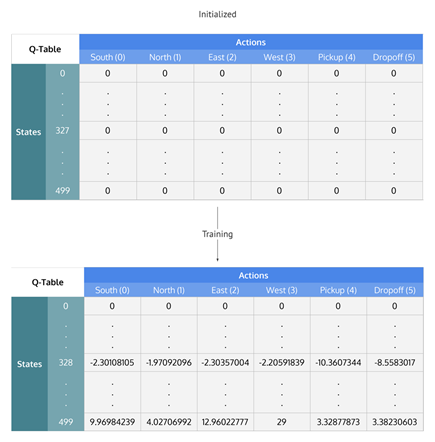

### Resumen del proceso de Q-Learning

    • Inicializar la tabla Q a todo ceros.
    • Comenzar a explorar acciones: para cada estado, seleccione cualquiera de las posibles acciones para el estado actual (S).
    • Ir al siguiente estado (S ') como resultado de esa acción (a).
    • Para todas las acciones posibles del estado (S '), seleccione la que tenga el valor Q más alto.
    • Actualizar los valores de la tabla Q utilizando la ecuación.
    • Establecer el siguiente estado como el estado actual.
    • Si se alcanza el estado objetivo, finalizar y repetir el proceso.

### Explotación de valores aprendidos y ϵ épsilon learning

Después de una fase de exploración aleatoria de acciones, los valores Q tienden a converger sirviendo a nuestro agente como una función de valor de acción que puede explotar para elegir la acción mejor para un estado dado.
Existe una compensación entre exploración (elegir una acción aleatoria) y explotación (elegir acciones basadas en valores Q ya aprendidos). Queremos evitar que la acción siga siempre la misma ruta y posiblemente se sobreajuste, por lo que introduciremos otro parámetro llamado ϵ "épsilon" para atender esto durante el entrenamiento.
En lugar de simplemente seleccionar la acción de valor Q mejor aprendida, a veces preferimos explorar más el espacio de acción. Un valor de épsilon más bajo da como resultado episodios con más penalizaciones (en promedio), lo cual es obvio porque estamos explorando y tomando decisiones al azar.

In [ ]:
# Primero se inicializa la Q-table a 500×6500×6 matrix of zeros:
env = gym.make("Taxi-v3")
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ejecutar el aprendizaje es un proceso lento pero se realiza una única vez. 
Una vez entrenado, podemos resolver cualquier problema de este entorno simplemente consultando la tabla y eligiendo la acción que maximiza la recompensa en cada paso (explotación). 
El algoritmo de entrenamiento que actualizará esta Q-table a medida que el agente explora el entorno durante miles de episodios. 

En la primera parte del bucle (while not done) decidimos si elegir una acción aleatoria o explotar los valores Q ya calculados. Esto se hace simplemente usando el valor épsilon y comparándolo con la función random.uniform (0, 1), que devuelve un número arbitrario entre 0 y 1.
Ejecutamos la acción elegida en el entorno para obtener el next_state y la recompensa por realizar la acción. Después de eso, calculamos el valor Q máximo para las acciones correspondientes al next_state, y con eso, podemos actualizar fácilmente nuestro valor Q al new_q_value:

In [ ]:
state, _ = env.reset()
print(state  )

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
episodes = 100000

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, episodes+1):
    state,_ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, _ = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


In [ ]:
# La tabla Q empezó inicializada a 0. Ahora ha cambiado despues de 100000 episodios. Vamos a ver cuales son los Q-values aprendidos en un estado de ejemplo. 
q_table[328]
# será aproximadamente valores aprendidos similares a:  array([ -2.40177682,  -2.27325184,  -2.38277076,  -2.35245849, -11.14888317, -10.43479034])  (no tiene por que ser exactamente igual)
# Tenemos el valor aprendido para las 6 acciones. El máximo lo encontramos en la segunda opción (norte) que es lo que ha aprendido. 

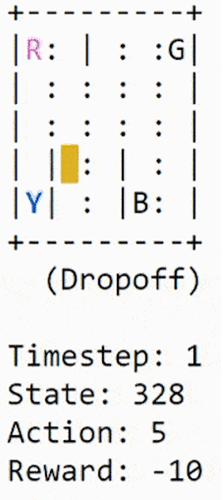

### Evaluar el comportamiento del agente despues del proceso de Q-learning 

Una vez entrenado el agente vamos a evaluar si el comportamiento de nuestro agente es adecuado con los valores que tenemos en la tabla Q. Ahora no se eligen nunca acciones aleatorias sino que siempre estaremos en __explotación__: la siguiente acción siempre se selecciona utilizando el mejor valor Q:

In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state,_ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[int(state)])
        state, reward, done, info, _ = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Podemos ver en la evaluación que el comportamiento del agente ha mejorado significativamente y _no hay penalizaciones_, lo que significa que realizó las acciones correctas de recogida / devolución con 100 pasajeros diferentes. Repasa lo que se considera penalización en este problema. 

Comparando los dos agentes vemos como aunque con Q-learning el agente comete errores inicialmente durante la exploración, una vez que ha explorado lo suficiente (visto la mayoría de los estados), puede actuar sabiamente maximizando las recompensas haciendo movimientos inteligentes. 

Veamos cuánto mejor es nuestra solución de Q-learning en comparación con el agente que realiza movimientos aleatorios.

Se puede evaluar al agente definiendo métricas. Las métricas pueden ser diferentes para cada problema. En este caso se proponen las siguientes métricas:

    • Número medio de penalizaciones por episodio: Cuanto menor sea el número, mejor será el desempeño de nuestro agente. Idealmente, nos gustaría que esta métrica fuera cero o muy cercana a cero.

    • Número promedio de pasos de tiempo por viaje: también queremos un número pequeño de pasos de tiempo por episodio, ya que queremos que nuestro agente dé pasos mínimos (es decir, el camino más corto) para llegar al destino.

    • Promedio de recompensas por movimiento: cuanto mayor sea la recompensa, significa que el agente está haciendo lo correcto. Es por eso que decidir las recompensas es una parte crucial del aprendizaje por refuerzo. En nuestro caso, dado que tanto los tiempos como las penalizaciones se recompensan negativamente, una recompensa promedio más alta significaría que el agente llega al destino lo más rápido posible con la menor cantidad de penalizaciones.


    Average rewards per move  -3.9012092102214075	0.6962843295638126
    Average number of penalties per episode	920.45	0.0
    Average number of timesteps per trip	2848.14	12.38

Estas métricas se calcularon en más de 100 episodios. 
Y como muestran los resultados, podemos concluir que nuestro agente de Q-learning tiene un buen comportamiento. 


In [ ]:
env.close()

### Hiperparámetros y optimizaciones

Los valores de `alpha`,` gamma` y `epsilon` que hemos utilizado han sido elegidos por intuición, prueba y error pero hay mejores formas de obtener buenos valores. Idealmente, los tres deberían disminuir con el tiempo porque a medida que el agente continúa aprendiendo, en realidad construye antecedentes más válidos y duraderos. 

En tus entrenamientos se pueden usar hiperparámetros variables que modifican dinámicamente su valor en función de la etapa del entrenamiento.

    • α: (la tasa de aprendizaje) debería disminuir a medida que continúa adquiriendo una base de conocimientos cada vez mayor.
    • γ: a medida que se acerca cada vez más al valor límite, su preferencia por la recompensa a corto plazo debería aumentar, ya que no estará el tiempo suficiente para obtener la recompensa a largo plazo, lo que significa que su gamma debería disminuir.
    • ϵ: a medida que desarrollamos nuestra estrategia, tenemos menos necesidad de exploración y más explotación para obtener más utilidad de nuestra política, por lo que a medida que aumentan los ensayos, épsilon debería disminuir.

In [ ]:
import random
from IPython.display import clear_output

def trainAgent(q_table,alpha,gamma,epsilon,iterations=100000):
    """Training the agent"""
    # For plotting metrics
    all_epochs = []
    all_penalties = []

    for i in range(1, iterations+1):
        state, _ = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info, _ = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

#       if i % 100 == 0:
#            clear_output(wait=True)
#            print(f"Episode: {i}")

    print("Training finished.\n")

In [ ]:
def solveTaxi(q_table,showF=False,time=.2):
    """Solves the Taxi Problem"""
     
    state,_= env.reset()
    epochs = 0
    penalties, reward = 0, 0
    reward = 0
    frames = [] # for animation
    done = False

    while not done:
        action = np.argmax(q_table[int(state)])
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        state, reward, done, info, _ = env.step(action)

        if reward == -10:
            penalties += 1

        

        epochs += 1
        
        if epochs >=1000:
            done = True


    print("Timesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    
    if (showF):
        print_frames(frames,time)        
    env.close()

In [3]:
import numpy as np

In [ ]:
%%time
env = gym.make("Taxi-v3",render_mode="ansi")

q_table = np.zeros([env.observation_space.n, env.action_space.n])
trainAgent(q_table,0.1,0.6,0.1,1000)

In [ ]:
solveTaxi(q_table,True)

¿Crees que ha funcionado bien el aprendizaje? ¿Cómo puedes mejorarlo?

### Ejemplo 2: Frozen Lake
Vamos a ver un segundo ejemplo con el entorno FrozenLake
https://gymnasium.farama.org/environments/toy_text/frozen_lake/

En este entorno el agente controla el movimiento de un personaje en un mundo de rejilla (por defecto 4x4 pero se puede ampliar)
Algunas baldosas son transitables (walkable) y otras hacen que el agente caiga al agua. 

La dirección real de movimiento del agente es incierta y solo depende parcialmente de la dirección elegida (porque puede resbalar en el hielo, sólo si el parámetro de inicialización is_slippery=True). 
La recompensa se obtiene cuando el agente llega a traves de un camino transitable a una casilla objetivo.


In [ ]:
import gymnasium as gym
problema = gym.make("FrozenLake-v1", render_mode="human",map_name="4x4",is_slippery=False)
print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()
problema.render()
env=problema

In [ ]:
# Realizando acciones aleatorias no se resuelve el problema :) puedes usar búsqueda o aprendizaje por refuerzo. 
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,_  = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

### Actividad

Realiza el entrenamiento para el agente Frozen Lake utilizando el código anterior y observa si mejora su comportamiento. Como has observado en el código anterior, en este caso sí funciona la visualización en modo "human" aunque el render() hace más lento el entrenamiento. Puedes probarlo, pero te recomiendo que no lo uses para entrenar. 

### Ejemplo 3. CliffWalking  (para entregar) 

Para esta práctica se pide entrenar y analizar en detalle el comportamiento de un agente para el problema CliffWalking (y/o BlackJack).
Puedes encontrar más información en la documentación de Gymnasium:
[https://gymnasium.farama.org/environments/toy_text/cliff_walking/]

El juego comienza con el jugador en la ubicación (3, 0) de una cuadrícula de 4x12, con el objetivo situado en (3, 11). Si el jugador llega al objetivo, el episodio termina.
Un precipicio se extiende a lo largo de (3, 1..10). Si el jugador se mueve a una ubicación del precipicio, vuelve al punto de inicio.

El jugador realiza movimientos hasta llegar al objetivo.

Adaptado del Ejemplo 6.6 (página 132) del libro Reinforcement Learning: An Introduction de Sutton y Barto.
Según el problema original (y la documentación) el precipicio puede configurarse como resbaladizo (desactivado por defecto), por lo que el jugador puede moverse perpendicularmente a la dirección deseada en ocasiones (ver is_slippery). Sin embargo, no está disponible la opción en la versión v0 proporcionada por gymnasium, por lo que no usaremos la opción.

In [ ]:
import gymnasium as gym
problema = gym.make("CliffWalking-v0", render_mode="human")# "human", "rgb_array", or "ansi"

In [ ]:
print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()
problema.render()
env=problema

Tamaño de espacio de estados Discrete(48)
Estado aleatorio 20
Hay 48  estados posibles.


In [7]:
for i_episode in range(20):
    observation = env.reset()
    for t in range(1000):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,_  = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

KeyboardInterrupt: 

¿Qué tal funciona la resolución con acciones aleatorias? 

Entrena un agente que resuelva el problema y comenta en detalle los resultados modificando los valores de los párametros, el número de episodios de aprendizaje, la recompensa por defecto. Define una métrica adecuada para el problema y evalua el aprendizaje para cada caso. 
Indica al final cual es la configuración de parámetros elegida. Al final del notebook se dan más detalles en **Actividad para Entregar**.

In [16]:

#Inicializar el problema sin render

import gymnasium as gym
problema = gym.make("CliffWalking-v0", render_mode="ansi")

print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()

episodes = 1000
methods = []
all_epochs = []
all_penalties = []


Tamaño de espacio de estados Discrete(48)
Estado aleatorio 39
Hay 48  estados posibles.


In [17]:
#Modelo 1 de aprendizaje, epsilon and alpha linear decay
import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

env=problema
methods.append("Epsilon[1,0] y alpha[0.1, 0.01] linear decay")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hiperparámetros
alpha_from = 0.1 #moderadamente alto para ser el factor de aprendizaje, irá decayendo hasta 0.01
alpha_to = 0.01
gamma = 0.9 #en un entorno inicialmente desconocido nos interesa el aprendizaje a largo plazo
epsilon_from = 1.0 #Al principio la exploración debe ser muy alta e irá decayendo hasta 0
epsilon_to = 0.0
epsilon = epsilon_from
alpha = alpha_from

# For plotting metrics
epochs_data = []
penalties_data = []


for i in range(1, episodes+1):
    state,_ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, _ = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1

        state = next_state

        fraq = i/episodes # fracción de episodios transcurridos

        epsilon = epsilon_from + (epsilon_to - epsilon_from)*fraq

        alpha = alpha_from + (alpha_to - alpha_from)*fraq
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha}, Epsilon: {epsilon}, Gamma {gamma}")
        print(f"q_matrix:\n: {q_table}")
    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")# "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Select the best action based on the trained Q-table or policy
    action = np.argmax(q_table[state])
    
    # Step through the environment using the chosen action
    next_state, reward, done, info, _ = env.step(action)
    
    # Render the environment at each step to visualize the agent's actions
    env.render()
    
    # Move to the next state
    state = next_state
# Close the environment when done
env.close()

Episode: 1000
Alpha: 0.009999999999999995, Epsilon: 0.0, Gamma 0.9
q_matrix:
: [[  -7.94108826   -7.71232069   -7.7123207    -7.94108816]
 [  -7.71232061   -7.45813415   -7.45813415   -7.94108846]
 [  -7.45813411   -7.17570463   -7.17570463   -7.71232064]
 [  -7.17570459   -6.86189403   -6.86189403   -7.45813407]
 [  -6.86189401   -6.51321559   -6.51321559   -7.17570459]
 [  -6.51321557   -6.12579511   -6.12579511   -6.86189401]
 [  -6.12579509   -5.6953279    -5.6953279    -6.51321558]
 [  -5.69532787   -5.217031     -5.217031     -6.12579508]
 [  -5.21703097   -4.68559      -4.68559      -5.69532789]
 [  -4.6855899    -4.0951       -4.0951       -5.21703089]
 [  -4.09509984   -3.439        -3.439        -4.68558942]
 [  -3.4389998    -3.43899906   -2.71         -4.09509896]
 [  -7.94108856   -7.45813417   -7.45813417   -7.71232074]
 [  -7.71232072   -7.17570463   -7.17570463   -7.71232075]
 [  -7.45813415   -6.86189404   -6.86189404   -7.45813417]
 [  -7.17570462   -6.5132156    -6.5

In [18]:
#Modelo 2 de aprendizaje, epsilon and alpha exponential decay

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

env = problema
methods.append("Epsilon[1,0] y alpha[0.1, 0.01] exponential decay")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hiperparámetros
alpha_from = 0.1  # Moderadamente alto para el factor de aprendizaje
alpha_to = 0.01  # Mínimo para evitar cambios bruscos al final
gamma = 0.9  # Fomenta el aprendizaje a largo plazo
epsilon_from = 1.0  # Alta exploración al principio
epsilon_to = 0.0  # Baja exploración al final

# Decay rates
alpha_decay_rate = np.power(alpha_to / alpha_from, 1 / episodes)
epsilon_decay_rate = np.power(epsilon_to / epsilon_from, 1 / episodes) if epsilon_to > 0 else 0.99

# Inicialización
alpha = alpha_from
epsilon = epsilon_from

# Para métricas
epochs_data = []
penalties_data = []

for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1
        state = next_state

    # Actualizar epsilon y alpha con decay exponencial
    epsilon = max(epsilon_to, epsilon * epsilon_decay_rate)
    alpha = max(alpha_to, alpha * alpha_decay_rate)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.0100, Epsilon: 0.0000, Gamma 0.9
q_matrix:
[[  -7.11678247   -6.88112647   -6.87791301   -7.12824863]
 [  -6.86570493   -6.63146336   -6.64486197   -7.12697661]
 [  -6.54703447   -6.34053801   -6.33509577   -6.8524481 ]
 [  -6.24469069   -6.05175215   -6.07032905   -6.53716258]
 [  -5.85690472   -5.72470607   -5.77028663   -6.2264122 ]
 [  -5.53276375   -5.36184508   -5.37438844   -5.88750778]
 [  -5.03945285   -4.96404025   -5.01694502   -5.47089566]
 [  -4.58871052   -4.57749991   -4.60925094   -5.05061267]
 [  -4.25715869   -4.16212013   -4.159794     -4.60241253]
 [  -3.76354586   -3.668954     -3.68614724   -4.09854113]
 [  -3.19319968   -3.17432966   -3.18792942   -3.49558143]
 [  -2.66551617   -2.65576352   -2.64491991   -2.97261609]
 [  -7.1548129    -6.95212944   -6.96403756   -6.97719371]
 [  -6.91689615   -6.72252531   -6.72088167   -7.03667341]
 [  -6.59655069   -6.47052424   -6.47686322   -6.73646046]
 [  -6.31280974   -6.18990244   -6.1977778    -6.

In [19]:
#Modelo 3 de aprendizaje, recompensas modificadas por distancia Manhattan e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas por la distancia Manhattan

class ManhattanRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Access the inner environment to retrieve its shape
        inner_env = env.unwrapped  # Unwrap the base environment
        self.grid_shape = inner_env.shape
        self.goal_state = self.grid_shape[0] * self.grid_shape[1] - 1
        self.goal_position = np.unravel_index(self.goal_state, self.grid_shape)
        self.cliff_positions = [
            np.unravel_index(row * self.grid_shape[1] + col, self.grid_shape)
            for col in range(1, self.grid_shape[1] - 1)
            for row in [self.grid_shape[0] - 1]
        ]

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        current_position = np.unravel_index(state, self.grid_shape)

        # Check if the agent is on a cliff
        if current_position in self.cliff_positions:
            reward = -100  # Penalization for falling into a cliff
        else:
            # Calculate Manhattan distance to the goal
            manhattan_distance = abs(current_position[0] - self.goal_position[0]) + abs(current_position[1] - self.goal_position[1])
            reward = -manhattan_distance  # Negative Manhattan distance as reward

        return state, reward, done, truncated, info

env = ManhattanRewardWrapper(problema)
methods.append("Modified Manhattan rewards, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado
epsilon = 0.3 # Exploración moderada, las propias recompensas del entorno le dicen donde explorar
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1
        state = next_state


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.3000, Gamma 0.9
q_matrix:
[[-61.59858318 -60.10666908 -59.98925041 -59.7248217 ]
 [-55.8630207  -54.89967054 -54.93987567 -57.69153756]
 [-50.14654726 -48.11685905 -48.11808344 -52.76939136]
 [-45.69232187 -41.3486567  -41.34796985 -53.0069623 ]
 [-39.81839124 -34.85314668 -34.85391031 -46.33617702]
 [-33.53579573 -28.7361775  -28.73560467 -38.76502958]
 [-26.60721639 -23.04344856 -23.0445605  -33.59922376]
 [-22.23060077 -17.8279377  -17.82809767 -27.46433866]
 [-16.32704206 -13.14338823 -13.14347411 -21.1987214 ]
 [-12.55453988  -9.0487668   -9.04876099 -16.50294341]
 [ -8.69331981  -5.60993392  -5.60992441 -11.59047543]
 [ -5.14995386  -5.02239917  -2.89999996  -7.56953193]
 [-65.67045129 -55.41865828 -55.41865828 -62.77543588]
 [-61.63904823 -48.24295365 -48.24295365 -62.87518474]
 [-55.07985479 -41.38105961 -41.38105961 -55.39639539]
 [-48.11718983 -34.86784401 -34.86784401 -48.24218783]
 [-41.30986332 -28.7420489  -28.7420489  -41.37989996]

In [20]:
#Modelo 4 de aprendizaje, penalización por paso e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas para penalizar cada paso y con ello caminos más largos

class StepPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, step_penalty=-1):
        super().__init__(env)
        self.step_penalty = step_penalty  # Penalización por cada paso

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        # Aplicar penalización fija por cada paso
        reward += self.step_penalty
        return state, reward, done, truncated, info


env = StepPenaltyWrapper(problema)
methods.append("Step penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado-bajo
epsilon = 0.5 # Exploración moderada-alta
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1
        state = next_state


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.5000, Gamma 0.9
q_matrix:
[[ -15.88149228  -15.42464146  -15.42464146  -15.87984694]
 [ -15.4245619   -14.91626834  -14.91626834  -15.88215605]
 [ -14.91626738  -14.35140927  -14.35140927  -15.42459541]
 [ -14.35140759  -13.72378808  -13.72378808  -14.91626697]
 [ -13.72378807  -13.0264312   -13.0264312   -14.35140927]
 [ -13.02643119  -12.25159022  -12.25159022  -13.72378808]
 [ -12.25159022  -11.3906558   -11.3906558   -13.02643116]
 [ -11.39065572  -10.434062    -10.434062    -12.25159021]
 [ -10.43406177   -9.37118      -9.37118     -11.39065537]
 [  -9.37117982   -8.1902       -8.1902      -10.43406171]
 [  -8.19019844   -6.878        -6.878        -9.37117396]
 [  -6.87796148   -6.87790995   -5.42         -8.19015176]
 [ -15.88217703  -14.91626834  -14.91626834  -15.42464151]
 [ -15.42464151  -14.35140927  -14.35140927  -15.42464151]
 [ -14.91626834  -13.72378808  -13.72378808  -14.91626834]
 [ -14.35140927  -13.0264312   -13.0264312   -14.

In [21]:
#Modelo 5 de aprendizaje, penalización por repetición de casillas e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas para penalizar casilla repetidas y con ello caminos redundantes

class BacktrackPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, backtrack_penalty=-3):
        super().__init__(env)
        self.backtrack_penalty = backtrack_penalty  # Penalización por retroceder
        self.visited_states = set()  # Estados visitados

    def reset(self, **kwargs):
        # Reiniciar el conjunto de estados visitados al comienzo de cada episodio
        self.visited_states = set()
        return super().reset(**kwargs)

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        # Aplicar penalización si el estado ya fue visitado
        if state in self.visited_states:
            reward += self.backtrack_penalty
        else:
            self.visited_states.add(state)
        return state, reward, done, truncated, info


env = BacktrackPenaltyWrapper(problema)
methods.append("Backtrack penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado-bajo
epsilon = 0.5 # Exploración moderada-alta
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1
        state = next_state


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.5000, Gamma 0.9
q_matrix:
[[ -17.49164615  -16.21730077  -17.94445893  -18.00745983]
 [ -16.88011876  -16.28758472  -16.80761786  -17.09247422]
 [ -16.71444861  -14.78190604  -16.29298719  -17.36279843]
 [ -16.08637592  -13.97748204  -13.69582768  -15.86741158]
 [ -14.75012438  -12.93283752  -13.11975558  -14.76518199]
 [ -14.02099046  -11.24668566  -12.55184383  -14.35606437]
 [ -12.91082127  -10.1788377    -9.86633923  -13.56742418]
 [ -12.37350003   -9.37852836   -9.56091132  -12.79806151]
 [ -11.6343709    -8.87168013   -8.46295954  -11.91593068]
 [ -10.87600672   -8.4458703    -8.14593429  -11.48983406]
 [ -10.07017376   -7.09484232   -7.25912782   -9.62182659]
 [  -9.03089271   -8.94333029   -4.84128527   -9.82580669]
 [ -16.68744704  -16.49486034  -18.95523672  -18.1710115 ]
 [ -16.41161729  -15.42587026  -17.60492679  -18.3683713 ]
 [ -15.19703709  -13.89187085  -15.18999589  -17.38571231]
 [ -14.73100643  -12.72764821  -14.9927423   -14.

In [22]:
#Modelo 6 de aprendizaje, recompensa por supervivencia
import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

class CliffPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, cliff_penalty=-100):
        super().__init__(env)
        self.cliff_penalty = cliff_penalty  # Penalización por caer en un acantilado
        self.grid_shape = env.unwrapped.shape
        self.cliff_positions = [
            np.unravel_index(row * self.grid_shape[1] + col, self.grid_shape)
            for col in range(1, self.grid_shape[1] - 1)
            for row in [self.grid_shape[0] - 1]
        ]

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        current_position = np.unravel_index(state, self.grid_shape)

        # Aplicar penalización si el estado actual es un acantilado
        if current_position in self.cliff_positions:
            reward += self.cliff_penalty

        return state, reward, done, truncated, info


env = CliffPenaltyWrapper(problema)
methods.append("Cliff penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.4 # Aprendizaje moderado
epsilon = 0.1 # Exploración baja
gamma = 0.2  # Fomenta el aprendizaje a corto plazo

# Para métricas
epochs_data = []
penalties_data = []


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1
        state = next_state


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.4000, Epsilon: 0.1000, Gamma 0.2
q_matrix:
[[  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.24999999   -1.24999999   -1.24999999   -1.24999999]
 [  -1.24999997   -1.24999997   -1.24999997   -1.24999998]
 [  -1.24999987   -1.24999988   -1.24999987   -1.2499999 ]
 [  -1.24999958   -1.24999954   -1.24999964   -1.24999957]
 [  -1.2499982    -1.24999822   -1.24999889   -1.24999863]
 [  -1.24999593   -1.24999292   -1.24999489   -1.24999606]
 [  -1.24997794   -1.24997037   -1.24997389   -1.24998783]
 [  -1.24987758   -1.24988295   -1.24988815   -1.24987676]
 [  -1.249618     -1.24950767   -1.24954377   -1.24953035]
 [  -1.24821125   -1.24789995   -1.24785207   -1.24813472]
 [  -1.24169144   -1.24169144   -1.23992299   -1.24485366]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.24999998   -1.24999997   -1.24999997   -1.24999998]
 [  -1.24999992   -1.24999987   -1.24999987   -1.

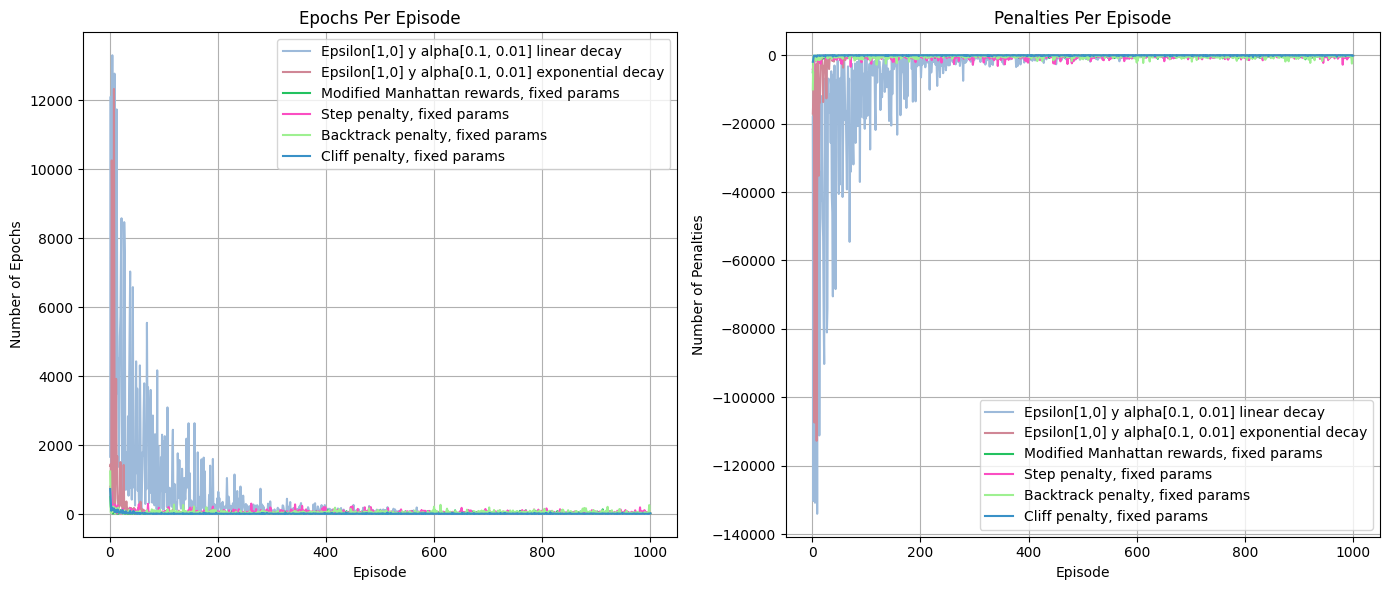

: 

In [ ]:
#Gráficas de aprendizaje


import matplotlib.pyplot as plt

method_colors = {method: f"#{random.randint(0, 0xFFFFFF):06x}" for method in methods}

# Create the plots
plt.figure(figsize=(14, 6))

# Plot epochs comparison
plt.subplot(1, 2, 1)
for method, epochs, color in zip(methods, all_epochs, method_colors.values()):
    plt.plot(range(1, len(epochs) + 1), epochs, label=method, color=color)
plt.title("Epochs Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Epochs")
plt.legend()
plt.grid(True)

# Plot penalties comparison
plt.subplot(1, 2, 2)
for method, penalties, color in zip(methods, all_penalties, method_colors.values()):
    plt.plot(range(1, len(penalties) + 1), penalties, label=method, color=color)
plt.title("Penalties Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Penalties")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Ejemplo 4. Blackjack  (para entregar) 

Entrenar un agente para el problema Blackjack. 
Puedes encontrar más información en la documentación de Gymnasium:
[https://gymnasium.farama.org/environments/toy_text/blackjack/]

Blackjack es un juego de cartas en el que el objetivo es vencer al crupier obteniendo cartas que sumen más cerca de 21 (sin exceder 21) que las cartas del crupier. El juego comienza con el crupier teniendo una carta boca arriba y otra boca abajo, mientras que el jugador tiene dos cartas boca arriba. Todas las cartas se extraen de un mazo infinito (es decir, con reposición).
Los valores de las cartas son los siguientes:
    Las figuras (Jota, Reina, Rey) tienen un valor de 10 puntos.
    Los ases pueden contarse como 11 (llamado "as usable") o como 1.
    Las cartas numéricas (del 2 al 9) tienen un valor igual a su número.
    El jugador tiene la suma de las cartas en su poder. Puede solicitar cartas adicionales (pedir) hasta que decida detenerse (plantarse) o exceda 21 (lo que resulta en pérdida inmediata, llamada quiebra).

Después de que el jugador se planta, el crupier revela su carta oculta y roba cartas hasta que su suma sea 17 o mayor. Si el crupier se pasa de 21, el jugador gana.
Si ni el jugador ni el crupier se pasan, el resultado (ganar, perder, empatar) se decide por quién se acerca más a 21.

Este entorno corresponde a la versión del problema de blackjack descrita en el Ejemplo 5.1 del libre _Reinforcement Learning: An Introduction de Sutton y Barto_.

Existen dos versiones del juego que se configuran con los parámetros al crear el entorno:

**natural=False**: indica si se debe otorgar una recompensa adicional por iniciar con un blackjack natural, es decir, comenzar con un as y un diez (suma total de 21).
    
**sab = False**: i Indica si se deben seguir exactamente las reglas descritas en el libro de Sutton y Barto. Si sab es True, el argumento natural será ignorado. Si el jugador logra un blackjack natural y el crupier no, el jugador ganará (recibiendo una recompensa de +1). La regla inversa no se aplica. Si tanto el jugador como el crupier obtienen un blackjack natural, el resultado será un empate (recompensa de 0   ).

### Ejemplo 4. Blackjack  (para entregar) 

Entrenar un agente para el problema Blackjack. 
Puedes encontrar más información en la documentación de Gymnasium:
[https://gymnasium.farama.org/environments/toy_text/blackjack/]


In [8]:
### Ejemplo 4. Blackjack

import gymnasium as gym
env=gym.make('Blackjack-v1', natural=False, sab=False, render_mode="human")

In [9]:
for i_episode in range(20):
    observation = env.reset()
    for t in range(1000):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,_  = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 2 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 2 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 2 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps
Episode finished after 1 timesteps


KeyboardInterrupt: 

## Actividad para entregar

Configura el aprendizaje por refuerzo para resolver alguno/s de los problemas Toy Text de Gymnasium utilizando distintos valores de configuración de los parámetros y observa qué configuración se comporta mejor.
     
    1. Define las métricas adecuadas para poder evaluar qué tal se comporta el agente entrenado con distintas configuraciones de parámetros.
    2. Realiza una variación dinámica de los valores de los parámetros durante el entrenamiento para que los valores no sean fijos 
    2. Modifica la recompensa por defecto para ver cómo afecta al entrenamiento. Observa cuál es la función de recompensa que se define por defecto (consulta en la documentación de gym). Mejórala reescribiendo el valor de reward y observa cómo afecta la mejora de la función de recompensa en el proceso de aprendizaje. Explica cómo has medido esta mejora.
    4. Realiza pruebas y saca conclusiones claras justificadas con el resumen de resultados. Puedes usar gráficas.  

    

### Actividad opcional 

Piensa si podrías facilmente resolver el problema del taxi con cualquiera de los algoritmos de búsqueda de AIMA. 
Sólo tendrías que definir una subclase de Problem en la que los estados utilicen la codificación numérica de los 500 estados del entorno env de Gym con las 6 acciones.
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

En el código de la clase Problem tendrás que hacer uso de las funciones de env, por ejemplo, para implementar la función result que aplica una acción en un estado tendrías que hacer una llamada a env.step:  

    env.next_state, reward, done, info, X = env.step(action)

Aunque no realices la implementación de la clase para resolver el problema con búsqueda, piensa cómo se comportaría la búsqueda en espacio de estados ¿resolvería el problema de forma sencilla? ¿lo resolvería mejor que con Q-Learning?